In [1]:
using Plots, LaTeXStrings
include("solar_insolation.jl");
using .SolarInsolationModel

In [2]:
# Vehicle Parameters
Base.@kwdef struct ASV_Params
    b_max::Float32 = 6500; # max soc in Wh
    b_min::Float32 = 0; # min soc in Wh
    panel_area::Float32 = 4; # m^2
    panel_efficiency::Float32 = 0.25; # 25% panel efficiency
    v_max::Float32 = 2.315; # max boat speed in m/s 
    v_min::Float32 = 0; # min boat speed in m/s

    k_h::Float32 = 10; # Hotel Load
    k_m::Float32 = 83; # Motor multiplier, need to tune
end

boat = ASV_Params();

# Environment Parameters
# dayOfYear = 180;
dayOfYear = 180;
lat = 35.0; # degrees
Δt = 0.1; # time step in hours
t = 0:Δt:24;
og_time = t;
t = t .+ 12;
t = t .% 24; # time over a day from noon to noon
n = length(t);

# Initial Conditions
b_0 = boat.b_max/2;

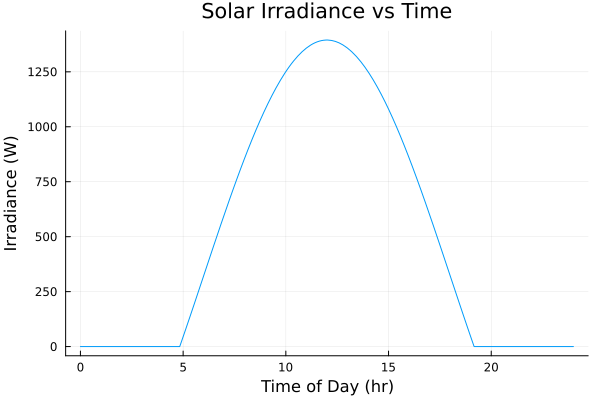

In [3]:
plot(solarTime -> max(0,SolarInsolation(dayOfYear, solarTime, lat))*1000, 0, 24);
xlabel!("Time of Day (hr)");
ylabel!("Irradiance (W)");
title!("Solar Irradiance vs Time");
plot!(legend=false)

# Lower Boundary

┌ Info: Saved animation to /home/kmgovind/Documents/research/cps/characterizing-ive/lower_epsAdjust.gif
└ @ Plots /home/kmgovind/.julia/packages/Plots/3BCH5/src/animation.jl:156


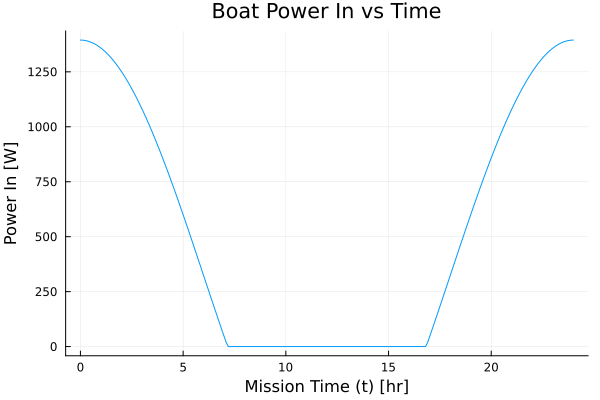

In [4]:
ϵ₋ = zeros(n); # energy deficit
Ps = zeros(n);
for i = 1:n
    Ps[i] = max(0, SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
    ϵ₋[i] = boat.k_h*(og_time[i] - og_time[1]) - sum(Ps[1:i]*Δt);
end

plot(og_time, ϵ₋);
xlabel!("Mission Time (t) [hr]");
ylabel!("Energy Deficit (ϵ₋) [Wh]");
title!("Energy Deficit (ϵ₋) vs Time (t)");
plot!(legend=false)

epsAdjust = @animate for i = 1:n
    # Compute Adjusted Energy Deficit curve
    ϵ₋dag = ϵ₋ .- ϵ₋[i];
    lcbf = max(0, maximum(ϵ₋dag[i:end]));

    # Plot
    plot(og_time, ϵ₋dag, label=L"$\epsilon_{-}^{\dagger}$");
    ylims!(-2500, 2500);
    vline!([og_time[i]], label="Time");
    hline!([0], label=false);
    hline!([lcbf], linestyle=:dash, label="LCBF");
    xlabel!("Mission Time (t) [hr]");
    ylabel!(L"Energy Deficit ($\epsilon_{-}^{\dagger}$) [Wh]");
    title!(L" Adjusted Energy Deficit ($\epsilon_{-}^{\dagger}$) vs Time (t)");
    plot!()
end
gif(epsAdjust, "lower_epsAdjust.gif")

lcbf = zeros(n);

for i = 1:n
    ϵ₋dag = ϵ₋ .- ϵ₋[i];
    lcbf[i] = max(0, maximum(ϵ₋dag[i:end]));
end
plot(og_time, lcbf);
xlabel!("Mission Time (t) [hr]");
ylabel!(L"Lower CBF $(h_l)$ [Wh]");
title!(L"Lower CBF $(h_l)$ vs Time (t)");
plot!(legend=false)

bdot_zerovel = zeros(n);
for i = 1:n
    bdot_zerovel[i] = max(0,SolarInsolation(dayOfYear, t[i], lat))*1000*boat.panel_area*boat.panel_efficiency;
end
plot(og_time, bdot_zerovel);
xlabel!("Mission Time (t) [hr]");
ylabel!("Power In [W]");
title!("Boat Power In vs Time")
plot!(legend=false)

# Upper Boundary

┌ Info: Saved animation to /home/kmgovind/Documents/research/cps/characterizing-ive/upper_epsAdjust.gif
└ @ Plots /home/kmgovind/.julia/packages/Plots/3BCH5/src/animation.jl:156


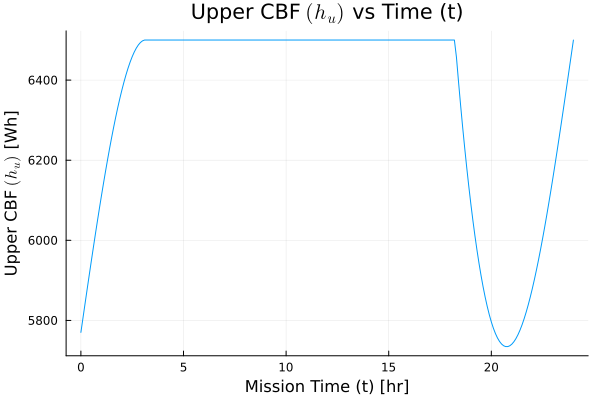

In [5]:
ϵ₊ = zeros(n); # energy surplus
Ps = zeros(n);
for i = 1:n
    Ps[i] = max(0, SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
    # boat.k_h*(og_time[i] - og_time[1])
    ϵ₊[i] = sum(Ps[1:i]*Δt) - (boat.k_h + boat.k_m*(boat.v_max^3))*(og_time[i] - og_time[1]);
end

plot(og_time, ϵ₊);
xlabel!("Mission Time (t) [hr]");
ylabel!("Energy Surplus (ϵ₊) [Wh]");
title!("Energy Surplus (ϵ₊) vs Time (t)");
plot!(legend=false)

epsAdjust = @animate for i = 1:n
    # Compute Adjusted Energy Deficit curve
    ϵ₊dag = ϵ₊ .- ϵ₊[i];
    ucbf = max(0, maximum(ϵ₊dag[i:end]));

    # Plot
    plot(og_time, ϵ₊dag, label=L"$\epsilon_{+}^{\dagger}$");
    ylims!(-2500, 2500);
    vline!([og_time[i]], label="Time");
    hline!([0], label=false);
    hline!([ucbf], linestyle=:dash, label="UCBF");
    xlabel!("Mission Time (t) [hr]");
    ylabel!(L"Energy Surplus ($\epsilon_{+}^{\dagger}$) [Wh]");
    title!(L" Adjusted Energy Surplus ($\epsilon_{+}^{\dagger}$) vs Time (t)");
    plot!()
end
gif(epsAdjust, "upper_epsAdjust.gif")

ucbf = zeros(n);

for i = 1:n
    ϵ₊dag = ϵ₊ .- ϵ₊[i];
    ucbf[i] = boat.b_max - max(0, maximum(ϵ₊dag[i:end]));
end
plot(og_time, ucbf);
xlabel!("Mission Time (t) [hr]");
ylabel!(L"Upper CBF $(h_u)$ [Wh]");
title!(L"Upper CBF $(h_u)$ vs Time (t)");
plot!(legend=false)

# Combined Barrier

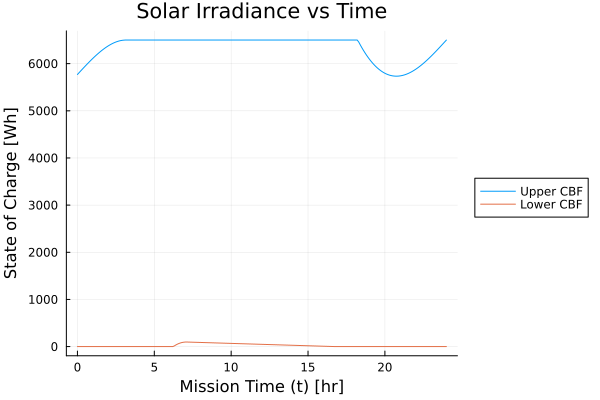

In [6]:
plot(og_time, ucbf, label="Upper CBF");
plot!(og_time, lcbf, label="Lower CBF");
xlabel!("Mission Time (t) [hr]");
ylabel!("State of Charge [Wh]");
title!("Solar Irradiance vs Time");
plot!(legend=:outerright)

# Iterative Co-state Learning with "PD control"
We have a continuous rate-based update to the co-state. At the end of each day, there is a proportional update.

p2min: 0.000749374
p2 end: 

0.0010621322019785328


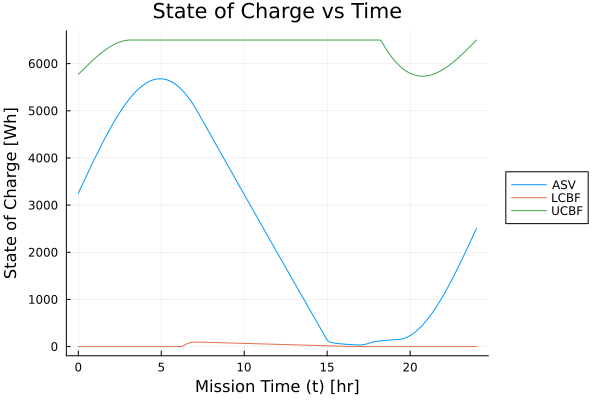

In [85]:
function batterymodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    soc_est = soc + (p_in - p_out)*dt; # power update in Wh
    soc_est = min(soc_est, boat.b_max); # cap charge at soc_max
    return soc_est;
end

function powermodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    out = p_in - p_out;
    return out;
end

function zeropower!(boat, dayOfYear, time, lat, soc, dt)
    p_in = max(0,SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    if p_in < boat.k_h
        vel = 0;
    else
        vel = cbrt((p_in - boat.k_h)/boat.k_m);
    end
    return vel;
end

k_p = -5e-5; # Learning P gain (-1e-5)
k_d = -1e-5; # Learning D gain 5e-5 -1e-5

xmax = 0; # best distance travel
pstar = 0;
num_iters = 100;
global p_list = zeros(num_iters);
global p2_list = zeros(n);
global error_list = zeros(num_iters);
global error_rate = zeros(num_iters);
p_list[1] = 0.5; # Initial guess for p2
p2min = 1/(3*boat.k_m*(boat.v_max^2));
println("p2min: ", p2min);

δ = 150; # 50Wh barrier on lcbf
lcbf_dot = diff(lcbf); # Derivative of lcbf

x = zeros(n);
b = ones(n)*b_0;
v = ones(n)*boat.v_max;
old_b = zeros(n);

for day = 1:1:num_iters

    global x = zeros(n);
    global b = ones(n)*b_0;
    global v = ones(n)*boat.v_max;

    p2 = p_list[day];

    for j in 2:n
        i = j-1;
        if i == 1 # initial conditions
            global x[i] = 0;
            global b[i] = b_0;
        end

        global p2_list[i] = p2;

        # println(p2);
        # Compute unconstrained velocity and SOC
        global v[i] = sqrt(1/(3 * p2 * boat.k_m)); # removed negative sign from numerator to let p be positive
        b_dot = powermodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);

        # Impose Boundary Conditions
        if b[i] <= lcbf[i]
            global v[i] = 0;
        elseif 0 < (b[i] - lcbf[i]) < δ
            global v[i] = (b[i] - lcbf[i])/δ * v[i] + (1 - (b[i] - lcbf[i])/δ) * boat.v_min;
        elseif b[i] >= ucbf[i]
            global v[i] = boat.v_max;
        elseif 0 < (ucbf[i] - b[i]) < δ
            global v[i] = (ucbf[i] - b[i])/δ * v[i] + (1 - (ucbf[i] - b[i])/δ) * boat.v_max;
        end

        # Move boat
        global x[j] = x[i] + (v[i] * 60 * 60) * Δt;
        global b[j] = batterymodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);
        global v[j] = v[i];

        # Continuous rate update
        if day != 1
            cont_error = b[j] - old_b[j];
            # pbar = log10(p2) + k_d * cont_error;
            pbar = log10(p_list[day-1]) + k_d * cont_error; # update co-state from previous day
            p2 = 10^pbar;
            # println("Day: ", day, "\t Time: ", j, "\t new p2: ", p2);
        end
    end

    # Learning adjustment
    if day < num_iters
        global error_rate[day] = 0;
        global error_list[day] = b[end] - b[1];
        if day != 1
            global error_rate[day] = error_list[day] - error_list[day-1];
        end
        pbar = log10(p_list[day]) + k_p * error_list[day];
        global p_list[day+1] = 10^pbar;
    end

    old_b = b;

    # Find optimal p2 and x
    if x[end] > xmax
        global xmax = x[end];
        global pstar = p2;
    end
end

println("p2 end: ", p_list[end]);

# Plot SOC vs Time
plot(og_time, b, label="ASV");
plot!(og_time, lcbf, label="LCBF");
plot!(og_time, ucbf, label="UCBF");
xlabel!("Mission Time (t) [hr]");
ylabel!("State of Charge [Wh]");
title!("State of Charge vs Time");
plot!(legend=:outerright)

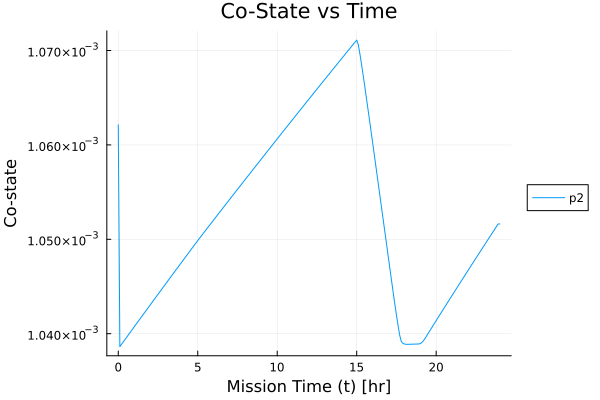

In [86]:
# Plot SOC vs Time
p2_list[end] = p2_list[end-1];
plot(og_time, p2_list, label="p2");
xlabel!("Mission Time (t) [hr]");
ylabel!("Co-state");
title!("Co-State vs Time");
plot!(legend=:outerright)

In [87]:
p_list[end-1]

0.0010386827386058043

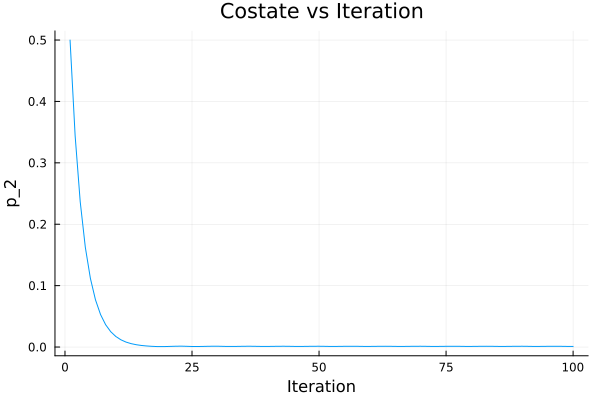

In [88]:
# Plot co-state value over time
plot(1:1:num_iters, p_list);
# ylims!(0, boat.v_max);
xlabel!("Iteration");
ylabel!("p_2");
title!("Costate vs Iteration");
plot!(legend=:false)
# savefig("costate_v_iteration: $(k_d).png")